In [24]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import sqlite3
import os
import re

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

from matplotlib import pyplot as plt

files = os.listdir()

In [2]:
files

['.ipynb_checkpoints',
 'Amazon_Fine_Food_Reviews_Analysis.ipynb',
 'database.sqlite',
 'hashes.txt',
 'practice_amazon_food_reviews.ipynb',
 'prep-final.csv',
 'Reviews.csv',
 'sparse_matrix.ipynb']

### `SQL` connection

In [3]:
con = sqlite3.connect('database.sqlite')
cursor = con.cursor()

### List all tables

In [4]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('Reviews',)]


### Read `SQL` data using `pandas`

* Consider data where `Score != 3`

In [5]:
# amazon_df = pd.read_csv('Reviews.csv')
# filtered_df = amazon_df[amazon_df['Score'] != 3]
# -------------
filtered_df = pd.read_sql_query(sql='SELECT * FROM Reviews WHERE Score != 3;', con=con)

In [6]:
filtered_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Creating a partition

In [7]:
make_partition = lambda x: 'negative' if x < 3 else 'positive'

pos_neg_score = filtered_df['Score'].map(make_partition)
filtered_df['Score'] = pos_neg_score

In [8]:
filtered_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Remove `book` reviews

In [9]:
def apply_mask_filteration(dframe, dcol, regex_str):
    filter_mask = dframe[dcol].str.lower().str.contains(regex_str)
    dframe.drop(index=dframe[dcol][filter_mask].index, inplace=True)

In [10]:
# look_for = ['book', 'read', 'books', 'reads', 'reading']

# apply_mask_filteration(dframe=filtered_df, dcol='Summary', regex_str=re.compile("\bbook\b"))
# apply_mask_filteration(dframe=filtered_df, dcol='Text', regex_str=re.compile("\bbook\b"))
# apply_mask_filteration(dframe=filtered_df, dcol='Summary', regex_str=re.compile("\bread\b"))
# apply_mask_filteration(dframe=filtered_df, dcol='Text', regex_str=re.compile("\bread\b"))
# apply_mask_filteration(dframe=filtered_df, dcol='Summary', regex_str=re.compile("\bbooks\b"))
# apply_mask_filteration(dframe=filtered_df, dcol='Text', regex_str=re.compile("\bbooks\b"))
# apply_mask_filteration(dframe=filtered_df, dcol='Summary', regex_str=re.compile("\breads\b"))
# apply_mask_filteration(dframe=filtered_df, dcol='Text', regex_str=re.compile("\breads\b"))
# apply_mask_filteration(dframe=filtered_df, dcol='Summary', regex_str=re.compile("\breading\b"))
# apply_mask_filteration(dframe=filtered_df, dcol='Text', regex_str=re.compile("\breading\b"))

# filtered_df.reset_index(drop=True, inplace=True)

In [11]:
filtered_df.shape

(525814, 10)

           Score
positive  443777
negative   82037


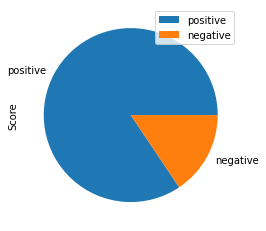

In [12]:
score_df = filtered_df['Score'].value_counts().to_frame()
print(score_df)
score_df.plot(kind='pie', subplots=True)
plt.show()

### Data Cleaning

In [13]:
filtered_df.shape

(525814, 10)

In [14]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525814 entries, 0 to 525813
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      525814 non-null  int64 
 1   ProductId               525814 non-null  object
 2   UserId                  525814 non-null  object
 3   ProfileName             525814 non-null  object
 4   HelpfulnessNumerator    525814 non-null  int64 
 5   HelpfulnessDenominator  525814 non-null  int64 
 6   Score                   525814 non-null  object
 7   Time                    525814 non-null  int64 
 8   Summary                 525814 non-null  object
 9   Text                    525814 non-null  object
dtypes: int64(4), object(6)
memory usage: 28.1+ MB


* Sort the data by `ProductId`

In [15]:
sorted_data = filtered_df.sort_values(
    by='ProductId', 
    axis=0, 
    ascending=True, 
    inplace=False, 
    kind='quicksort', 
    na_position='last'
)

* De-Duplication

In [16]:
final_df = sorted_data.drop_duplicates(
    subset=['UserId','ProfileName','Time','Text'],
    keep='first',
    inplace=False,
)

In [17]:
final_df.shape

(364173, 10)

* HelpfulnessNumerator $\leq$ HelpfulnessDenominator

In [18]:
final_df = final_df[final_df['HelpfulnessNumerator'] <= final_df['HelpfulnessDenominator']]
final_df.reset_index(drop=True, inplace=True)

In [19]:
final_df.shape

(364171, 10)

           Score
positive  307061
negative   57110


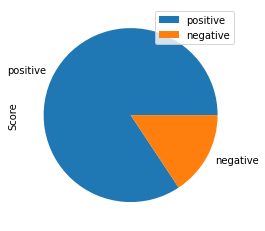

In [20]:
score_df = final_df['Score'].value_counts().to_frame()
print(score_df)
score_df.plot(kind='pie', subplots=True)
plt.show()

### Final Preprocessed Data

In [32]:
prep_final = pd.read_csv('prep-final.csv')

In [33]:
prep_final.shape

(364171, 11)

In [34]:
prep_final_nn = prep_final.dropna(axis=0)

In [35]:
ptexts = prep_final_nn['CleanedText'].to_list()

### BoW

In [38]:
# bow_count_vect = CountVectorizer()
# bow_count_vect.fit(ptexts)